In [1]:
from astropy.io import ascii 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#we open the match table
home='/home/igonzalez/MAUCA/C2PU/NGC869/' 
file=home+'match_table_r_g_gaia' 
data=ascii.read(file)
print(data)

FLUX_ISO_1 MAG_ISO_1 MAG_ISOCOR_1 ...  Rad    Lum        Separation     
---------- --------- ------------ ... ----- ------- --------------------
 26580.043  18.93861    18.899534 ...  8.89 242.756   0.1899419355621246
 21511.328 19.168331    19.122416 ...  8.84 193.307  0.11426936225351374
 2193.0784 21.647366    21.356857 ...  0.98   0.634  0.26918741794646284
  1196.639 22.305092    21.863258 ...  1.06   0.651  0.29580242475513513
 1924.0597 21.789454     21.41586 ...  3.09  23.652   0.3596675275956628
 1364.4548 22.162601    21.795694 ...  4.29  12.385  0.05857205206265806
 10949.688 19.901495    19.798637 ...  5.29    77.0  0.31575572200503665
 3865.8628 21.031883    20.844685 ...  5.29  48.476  0.15294749292748167
 2452.3518 21.526043    21.240417 ...  3.49  31.694  0.18367888176174268
 1309.1149 22.207556    21.538795 ...  2.09   2.429  0.24849057557574844
       ...       ...          ... ...   ...     ...                  ...
   2575.16  21.47299    21.234562 ...  3.56  33.537

In [3]:
print(data[1]) #prints the file header

FLUX_ISO_1 MAG_ISO_1 MAG_ISOCOR_1 MAG_AUTO_1 X_IMAGE_1 Y_IMAGE_1   ALPHA_J2000_1     DELTA_J2000_1   FLUX_ISO_2 MAG_ISO_2 MAG_ISOCOR_2 MAG_AUTO_2 X_IMAGE_2 Y_IMAGE_2   ALPHA_J2000_2    DELTA_J2000_2       Separation_1        _RAJ2000         _DEJ2000        _r       RA_ICRS     e_RA_ICRS    DE_ICRS     e_DE_ICRS       Source        Plx  e_Plx   pmRA  e_pmRA  pmDE  e_pmDE Dup    FG     e_FG    Gmag  e_Gmag   FBP    e_FBP  BPmag  e_BPmag   FRP    e_FRP   RPmag  e_RPmag BP-RP   RV e_RV  Teff    AG   E(BP-RP) Rad    Lum        Separation    
---------- --------- ------------ ---------- --------- --------- ----------------- ----------------- ---------- --------- ------------ ---------- --------- --------- ----------------- ---------------- ------------------- ---------------- ---------------- -------- -------------- --------- -------------- --------- ------------------ ----- ------ ------ ------ ------ ------ --- -------- ------ ------- ------ -------- ------ ------ ------- -------- ------ 

In [4]:
#SDSS conversion of the tables
G_gaia=data['Gmag']
bp_rp=data['BP-RP']
R_mag=data['MAG_ISO_1']
G_mag=data['MAG_ISO_2']
g_SDSS=G_gaia - (0.13518+(0.46245*bp_rp)+(0.25171*(bp_rp)**2)-(0.021349*(bp_rp)**3)) #corrected gaia mag for g
r_SDSS=G_gaia -(-0.12879-(0.24662*bp_rp)+(0.027464*(bp_rp)**2)+(0.049465*(bp_rp)**3))#corrected gaia mag for r

Photometric calibration:
  RANSAC G Slope: 0.894
  RANSAC G ZP   : -7.14


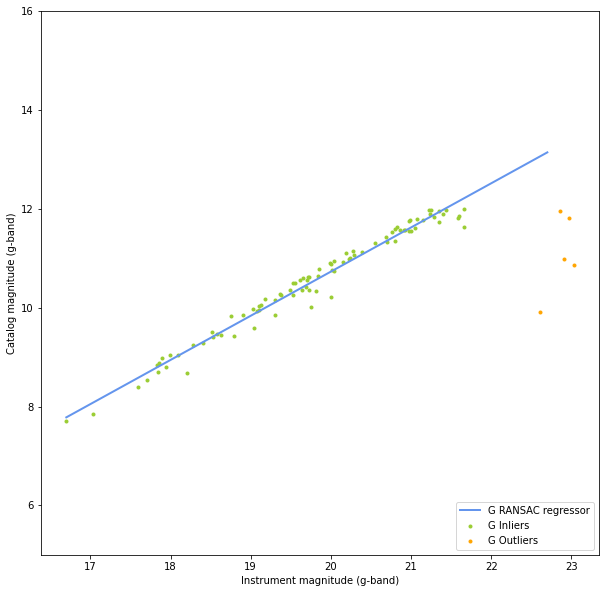

In [5]:
#RANSAC linear regression to get the zeropoint
from sklearn import linear_model

mag_max = 12
mag_min = 6

cond=(g_SDSS<mag_max) & (g_SDSS>mag_min) # we select the bright sources only

x1 = G_mag[cond].reshape(-1,1)
y1 = g_SDSS[cond].reshape(-1,1)

ransac = linear_model.RANSACRegressor()
ransac.fit(x1, y1)

print('Photometric calibration:')
print( f'  RANSAC G Slope: {ransac.estimator_.coef_[0][0]:.3f}')
print( f'  RANSAC G ZP   : {ransac.estimator_.intercept_[0]:.2f}')

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_x1 = np.arange(x1.min(), x1.max())[:, np.newaxis]
line_y1_ransac = ransac.predict(line_x1)


lw = 2
plt.figure(figsize=(10,10))
plt.scatter(x1[inlier_mask], y1[inlier_mask], color='yellowgreen', marker='.',
            label='G Inliers')
plt.scatter(x1[outlier_mask], y1[outlier_mask], color='orange', marker='.',
            label='G Outliers')
plt.plot(line_x1, line_y1_ransac, color='cornflowerblue', linewidth=lw,
         label='G RANSAC regressor')


plt.legend(loc='lower right')
plt.ylim([5,16])
plt.xlabel('Instrument magnitude (g-band)')
plt.ylabel('Catalog magnitude (g-band)')

zero_point_1=np.abs(ransac.estimator_.intercept_[0]) #the zero-point is the intercept ("ordonnée à l'origine")


Photometric calibration:
  RANSAC R Slope: 0.950
  RANSAC R ZP   : -7.26


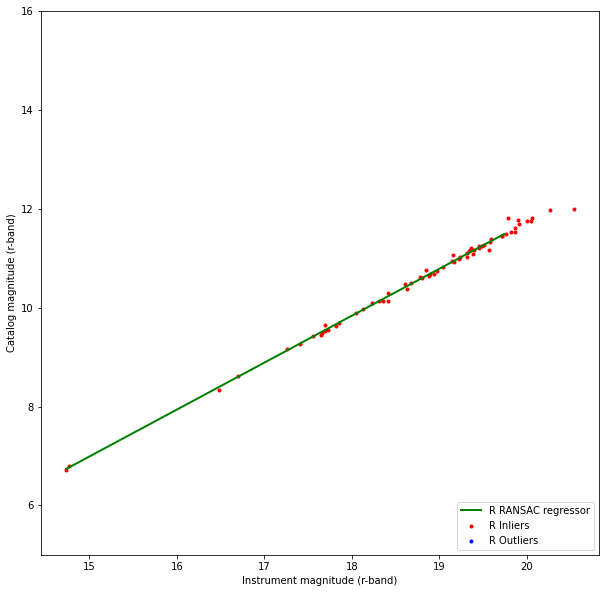

In [6]:
from sklearn import linear_model

mag_max = 12
mag_min = 6

cond=(r_SDSS<mag_max) & (r_SDSS>mag_min)

x2 = R_mag[cond].reshape(-1,1)
y2 = r_SDSS[cond].reshape(-1,1)

ransac = linear_model.RANSACRegressor()
ransac.fit(x2, y2)

print('Photometric calibration:')
print( f'  RANSAC R Slope: {ransac.estimator_.coef_[0][0]:.3f}')
print( f'  RANSAC R ZP   : {ransac.estimator_.intercept_[0]:.2f}')

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_x2 = np.arange(x2.min(), x2.max())[:, np.newaxis]
line_y2_ransac = ransac.predict(line_x2)

lw = 2
plt.figure(figsize=(10,10))
plt.scatter(x2[inlier_mask], y2[inlier_mask], color='red', marker='.',
            label='R Inliers')
plt.scatter(x2[outlier_mask], y2[outlier_mask], color='blue', marker='.',
            label='R Outliers')
plt.plot(line_x2, line_y2_ransac, color='green', linewidth=lw,
         label='R RANSAC regressor')

plt.legend(loc='lower right')
plt.ylim([5,16])
plt.xlabel('Instrument magnitude (r-band)')
plt.ylabel('Catalog magnitude (r-band)')

zero_point_2=np.abs(ransac.estimator_.intercept_[0])

In [7]:
print("Z_p for g-band: ",zero_point_1, "Z_p for r-band: ",zero_point_2)

Z_p for g-band:  7.142843747293913 Z_p for r-band:  7.263913334751329


In [8]:
#magnitude correction for the NGC 869 cross-matched catalog
R_corr=np.zeros(225)
G_corr=np.zeros(225)

for i in range(225):
    x=R_mag[i]-(zero_point_2)
    R_corr[i]=x
    y=G_mag[i]-(zero_point_1)
    G_corr[i]=y

print('corrected R-mag: ',R_corr,'corrected G-mag: ',G_corr)

corrected R-mag:  [11.67469667 11.90441767 14.38345267 15.04117867 14.52554067 14.89868767
 12.63758167 13.76796967 14.26212967 14.94364267 13.76949967 12.05395767
 15.24739567 14.23534067 14.56564067 11.89744667 15.20338667 16.20235667
 12.60027967 14.40748867 16.00404967 14.19767067 14.68181067 15.43004467
 12.51455167 15.76097567 12.09051067 10.38559467  9.22210967 13.79159967
 15.36896767 15.39238667 15.40145567 16.03490667 15.19867367 15.15029267
 14.66165267 13.76195967 11.36256267 11.96548567 14.71729967 14.76082267
 15.12177567 15.76384767 14.54994467 15.60290067 13.57837667 12.12237667
  7.50425267 11.71360667 14.36548667 12.44823367 15.47736667 15.69365767
 16.25351367 13.11036967 15.15917667 14.53112467 14.11430967 16.16374667
 14.62123667 13.94385067 16.03144667 13.00078067 16.09048367 14.84432867
 13.49583367 14.25999567 14.71171467 15.80337667 14.01009667 11.88566067
 14.57584667 14.07227167 14.17798467 14.36344367 14.99243267 15.30657667
 15.77492967 15.59521567 11.34299

In [9]:
color=G_corr-R_corr
print(color)

[ 0.31060659  0.32473859  1.12669059  1.46337359  0.45539259  1.23596159
  0.41282359  0.48201659  0.34732459  1.30680159  0.43089559  0.44663159
  0.93336359  0.48685759  0.84594559  0.70943959  0.70177759  0.76247359
  0.24932659  1.31273159  1.37604959  0.47422659  0.64596659  1.01752159
  0.57514659  1.20775259  0.49503959  0.29693659  0.33465659  0.31064159
  0.72881559  2.01299659  0.82732859  1.34020759  1.05081259  0.56118959
  0.57014459  0.31765259  0.24421359  0.42075159  0.67271059  0.78305759
  1.10611759  0.82360159  0.46705859  0.74506059  0.35713759  0.29168359
  0.53573059  0.31733759  0.57456259  0.42536059  0.72199959  1.06249659
  0.98968659  0.45246559  0.60408259  0.90131259  0.56021459  0.41637459
  0.73039259  0.40169559  1.36403159  0.40197459  1.31143259  0.68863959
  0.33885559  0.56015259  0.74540359  1.64117959  0.52477059  0.33668759
  0.67862559  0.50089159  0.60901359  0.56515759  1.68025059  0.83290759
  1.39255759  1.03116859  0.55304959  0.36641359  0

Text(0, 0.5, 'Color (g-magnitude - r-magnitude)')

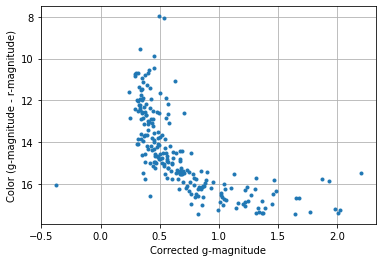

In [10]:
#first color-magnitude diagram
plt.grid()
plt.plot(color, G_corr,".")
plt.gca().invert_yaxis()
plt.xlabel('Corrected g-magnitude')
plt.ylabel('Color (g-magnitude - r-magnitude)')

In [11]:
plx=data['Plx']
e_plx=data['e_Plx']

#we take parallaxes with errors <10%
corr_plx=np.zeros(225)
for i in range(225):
    if e_plx[i]<0.1:
        x=plx[i]
        corr_plx[i]=x

#distance = 1/parallax and the parallax is in milliarcsecs
dist=np.zeros(225)
for i in range(225):
    x=1/(corr_plx[i]*10**(-3))
    dist[i]=x

R_abs=np.zeros(225)
G_abs=np.zeros(225)

#we go from apparent magnitude to absolute
for i in range(225):
    x=R_corr[i]-(5*np.log10(dist[i])-5)
    R_abs[i]=x
    y=G_corr[i]-(5*np.log10(dist[i])-5)
    G_abs[i]=y
    
print('absolute R-mag: ',R_abs,'absolute G-mag: ',G_abs)

absolute R-mag:  [-0.05009163  0.16564937  6.68478381  6.91033439  2.75461626  3.57308668
  1.06360234  1.79557228  2.3938315   5.18837518  1.30945329  0.10832267
  3.36880614  2.07986774  2.38423237  6.4730734   3.32994892  4.37927269
  1.07725021  5.63258302  4.14803709  2.41048785  4.44068321  3.42126062
  0.98362593  3.68715098 -0.26233756 -0.9901599  -2.41832527  1.78500516
         nan  5.96043242  3.27797233  3.83981694        -inf  3.31156655
  2.73982501  1.60003188 -0.29550775 -0.09371625  2.88817402  3.03363044
  3.11189603  3.54354985  2.39622883  1.55735925  2.08319256  0.59803315
 -4.31380941  2.3601222   2.23216587  0.0467175   3.49254695  3.8238189
  4.5991679   3.26862363  3.19376929  2.51301039  2.01494129  4.03042587
  2.8241407   1.73979161  4.27519773  0.94045741  3.94378202        -inf
  1.04587623  2.33658895  2.71603485  3.89570913  1.94190778 -0.41269196
  2.80246667  1.84350571  2.34785044  2.57576627  6.75247649        -inf
  3.8473065   3.52364706        -in

<ipython-input-11-1ed4527c4c21>:14: RuntimeWarning: divide by zero encountered in double_scalars
  x=1/(corr_plx[i]*10**(-3))
<ipython-input-11-1ed4527c4c21>:22: RuntimeWarning: invalid value encountered in log10
  x=R_corr[i]-(5*np.log10(dist[i])-5)
<ipython-input-11-1ed4527c4c21>:24: RuntimeWarning: invalid value encountered in log10
  y=G_corr[i]-(5*np.log10(dist[i])-5)


<ipython-input-12-ea6e98e34dbf>:3: RuntimeWarning: invalid value encountered in subtract
  color_abs=G_abs - R_abs


Text(0.5, 0, 'Color (absolute G-mag - absolute R-mag)')

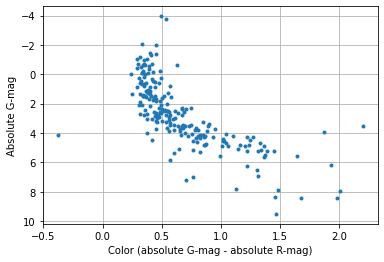

In [12]:
#CMD with absolute magnitudes
plt.grid()
color_abs=G_abs - R_abs
plt.plot(color_abs, G_abs,".")
plt.gca().invert_yaxis()
plt.ylabel('Absolute G-mag')
plt.xlabel('Color (absolute G-mag - absolute R-mag)')

In [13]:
#we open the isochrone file
home='/home/igonzalez/MAUCA/C2PU/NGC869/' 
file=home+'iso14.dat' 
iso_table=ascii.read(file,header_start=14)
print(iso_table)

  Zini   MH  logAge      Mini       int_IMF    ...  gmag   rmag   imag   zmag 
------- --- ------- ------------- ------------ ... ------ ------ ------ ------
0.01471 0.0     6.0  0.0900000036 1.0816895962 ... 14.676 12.754 10.401  8.888
0.01471 0.0     6.0  0.0913396776 1.0944002867 ... 14.619 12.699 10.355  8.848
0.01471 0.0     6.0  0.1000000015 1.1711064577 ... 14.263 12.357 10.065  8.602
0.01471 0.0     6.0   0.110970892 1.2567189932 ... 13.898  12.01  9.767  8.345
0.01471 0.0     6.0  0.1200000048 1.3193155527 ... 13.625 11.753  9.543  8.149
0.01471 0.0     6.0  0.1366447806 1.4200681448 ... 13.201  11.36  9.193  7.841
0.01471 0.0     6.0  0.1400000006 1.4384527206 ... 13.127 11.291  9.131  7.786
0.01471 0.0     6.0  0.1485859454 1.4829999208 ...  12.95 11.126  8.987   7.66
0.01471 0.0     6.0  0.1605244577 1.5396661758 ... 12.702 10.894  8.781   7.48
0.01471 0.0     6.0  0.1663414091 1.5653276443 ...  12.67 10.861  8.762  7.469
    ... ...     ...           ...          ... ...  

In [14]:
#we create a table containing the data associated to a certain logarithmic age (one for each isochrone)
from astropy.table import unique
logAge=unique(iso_table, keys='logAge')['logAge'].data

0 6.0 254
1 6.47712 364
2 6.69897 392
3 6.8451 245
4 6.95424 248


<ipython-input-15-14df7222988c>:3: RuntimeWarning: invalid value encountered in subtract
  color_abs=G_abs - R_abs


Text(0.5, 0, 'Absolute g-mag')

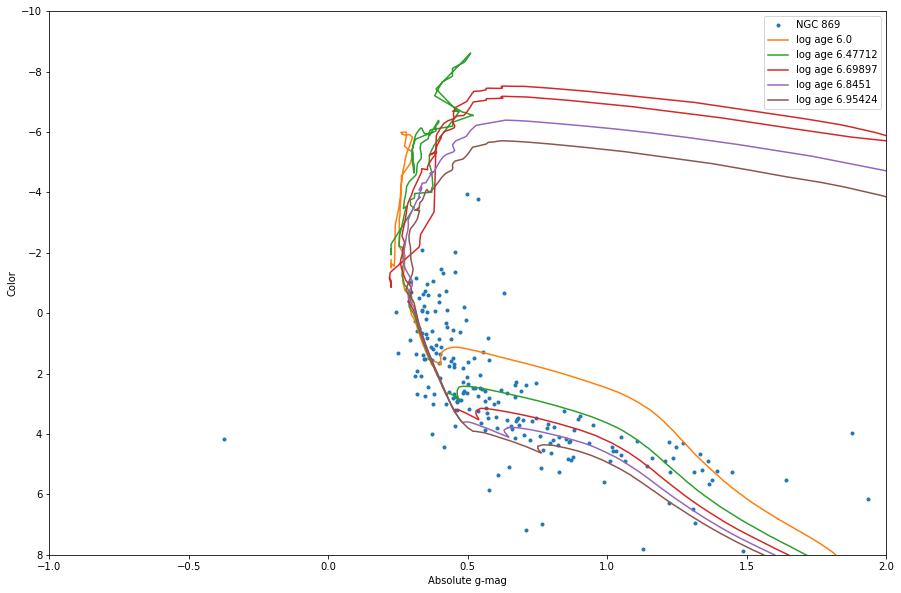

In [15]:
#CMD created with our data
plt.figure(figsize=(15,10))
color_abs=G_abs - R_abs
plt.plot(color_abs, G_abs,".",label='NGC 869')

#CMD (isochrone) with data from Parsec website
for i, la in enumerate(logAge):
    selected=iso_table[iso_table['logAge']== la]
    print(i, la, len(selected)) #prints the age associated to the isochrone and the lines associated in the table
    gmag=selected['gmag']
    rmag=selected['rmag']
    g_r=gmag-rmag
    plt.plot(g_r+0.1,gmag,"-",label=f'log age {la}')
    
    
    
plt.gca().invert_yaxis()
plt.xlim(-1,2)
plt.ylim(8,-10)
plt.legend(loc='best') 
plt.ylabel("Color")
plt.xlabel("Absolute g-mag")